In [1]:
import scdrs
import scanpy as sc
sc.set_figure_params(dpi=125)
from anndata import AnnData
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings("ignore")

In [2]:
# scdrs.util.load_h5ad is a simple wrapper to read h5ad files
# with basic data filtering
adata = sc.read_h5ad("E:/anaconda/jupyter notebook/bd_brain.h5ad")


# load geneset, convert homologs and overlap gene names to adata.var_names
dict_gs = scdrs.util.load_gs(
    "E:/anaconda/jupyter notebook/geneset.gs",
    src_species="human",
    dst_species="human",
    to_intersect=adata.var_names,
)

# load covariates
#df_cov = pd.read_csv("data/cov.tsv", sep="\t", index_col=0)

# preprocess data to
# (1) regress out from covariates
# (2) group genes into bins by mean and variance
scdrs.preprocess(adata, n_mean_bin=20, n_var_bin=20, copy=False)

In [3]:
new_cluster_names = [
    'Microglial cell_3', 'Microglial cell_1',
    'Neuron', 'Astrocyte_1',
    'Oligodendrocyte progenitor cell', 'Astrocyte_2',
    'Neural progenitor cell', 'Ventral medial ganglionic eminence precursor cell',
    'Progenitor cell','ADCY1 group',
    'Microglial cell_2','Astrocyte_3']
adata.rename_categories('leiden', new_cluster_names)

In [4]:
adata.obs.leiden

X.data.sqcheng.boluncheng.Proj_scDRSbam.03_align_all.C1.133.A10_CGAGGCTG.GCGTAAGA_L005_R1_001_trimmed.fq.gz.hs2.bam            Astrocyte_1
X.data.sqcheng.boluncheng.Proj_scDRSbam.03_align_all.C1.133.A12_GTAGAGGA.GCGTAAGA_L005_R1_001_trimmed.fq.gz.hs2.bam      Microglial cell_3
X.data.sqcheng.boluncheng.Proj_scDRSbam.03_align_all.C1.133.A1_TAAGGCGA.GCGTAAGA_L005_R1_merged_trimmed.fq.gz.hs2.bam          Astrocyte_1
X.data.sqcheng.boluncheng.Proj_scDRSbam.03_align_all.C1.133.A2_CGTACTAG.GCGTAAGA_L005_R1_001_trimmed.fq.gz.hs2.bam             Astrocyte_1
X.data.sqcheng.boluncheng.Proj_scDRSbam.03_align_all.C1.133.A3_AGGCAGAA.GCGTAAGA_L005_R1_001_trimmed.fq.gz.hs2.bam       Microglial cell_1
                                                                                                                               ...        
X.data.sqcheng.boluncheng.Proj_scDRSbam.03_align_all.PEC_Yale_SingleCellRNAseq_HSB325_72_H3_trimmed.fq.gz.hs2.bam              Astrocyte_2
X.data.sqcheng.boluncheng.P

In [5]:
dict_df_score = dict()
for trait in dict_gs:
    gene_list, gene_weights = dict_gs[trait]
    dict_df_score[trait] = scdrs.score_cell(
        data=adata,
        gene_list=gene_list,
        gene_weight=gene_weights,
        ctrl_match_key="mean_var",
        n_ctrl=1000,
        weight_opt="vs",
        return_ctrl_raw_score=False,
        return_ctrl_norm_score=True,
        verbose=False,
    )

Computing control scores: 100%|███████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.12it/s]


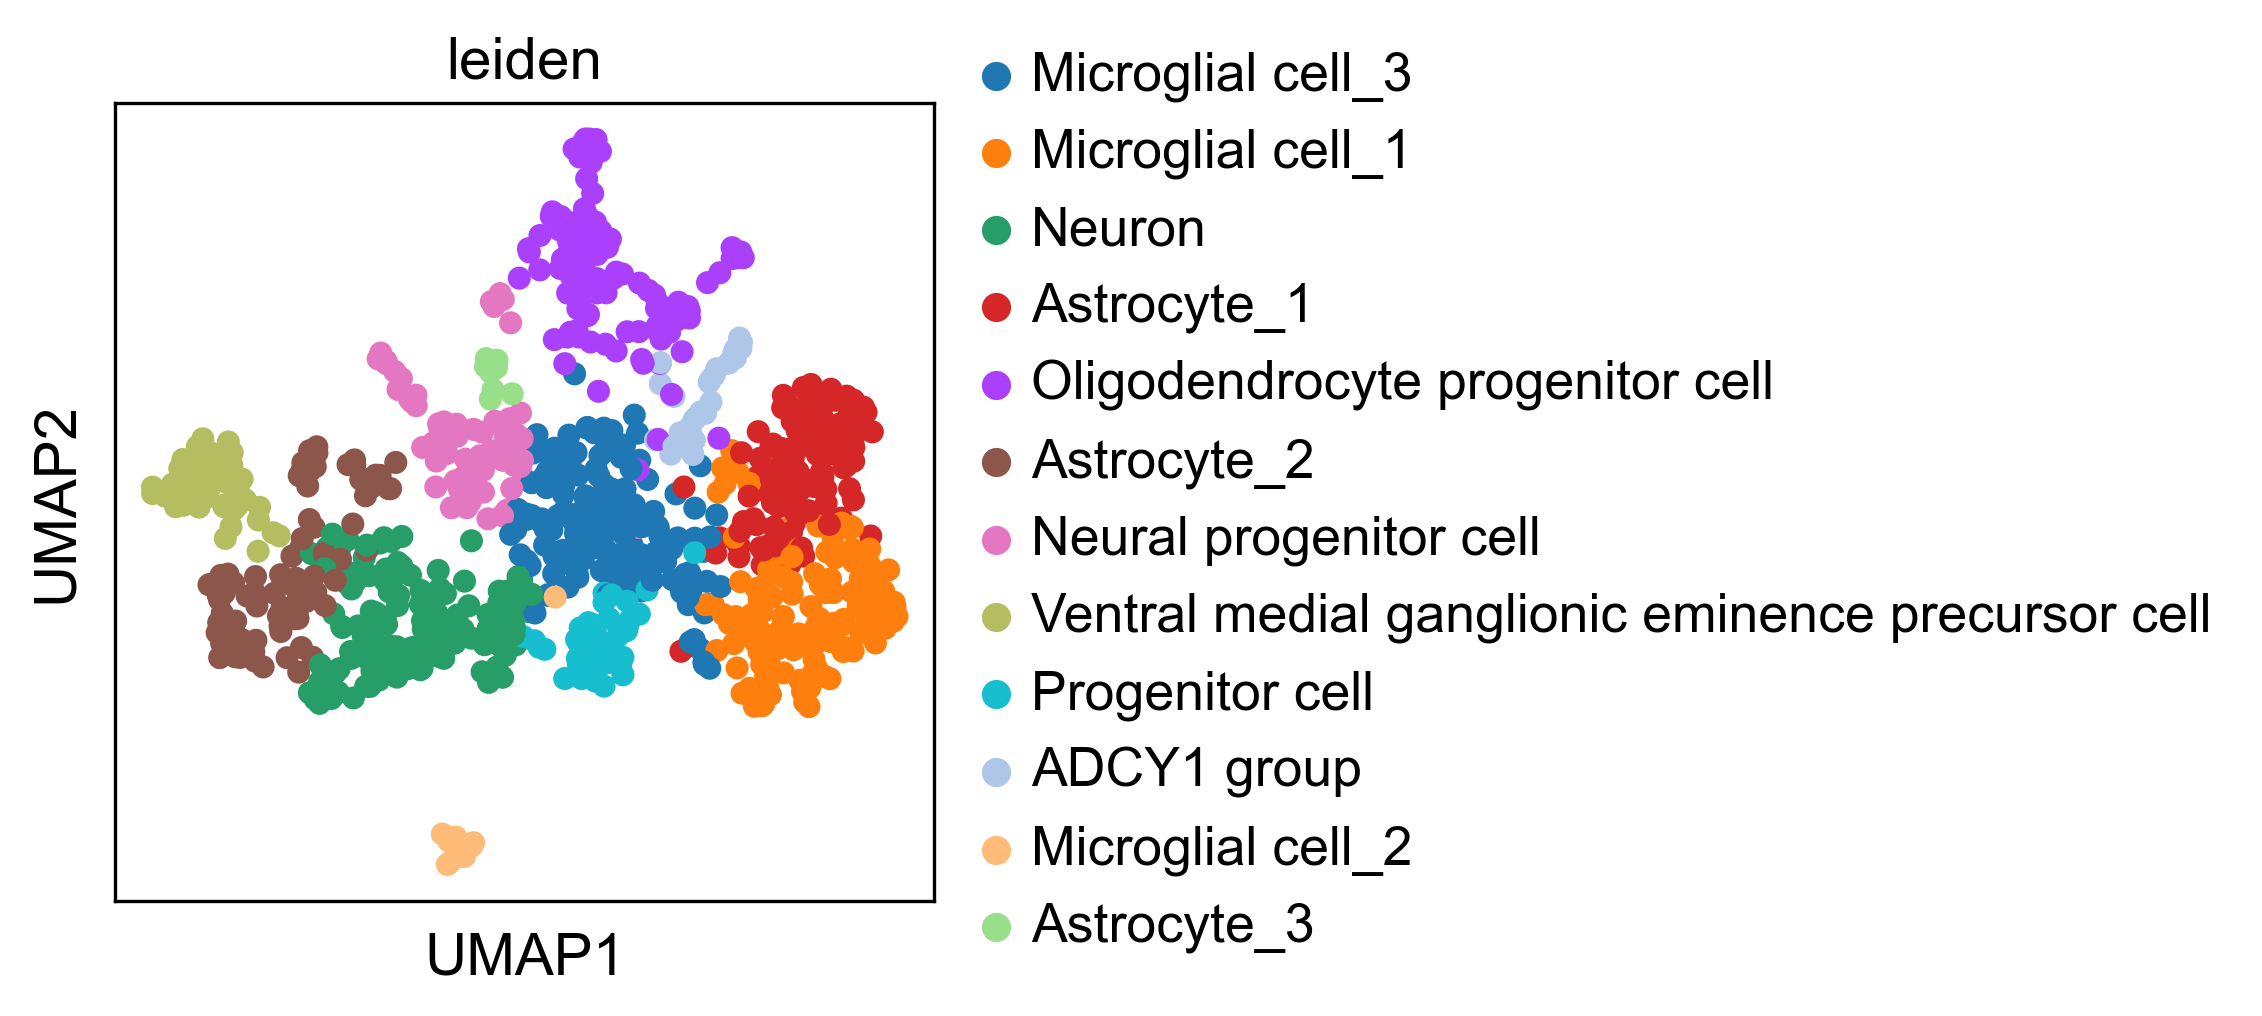

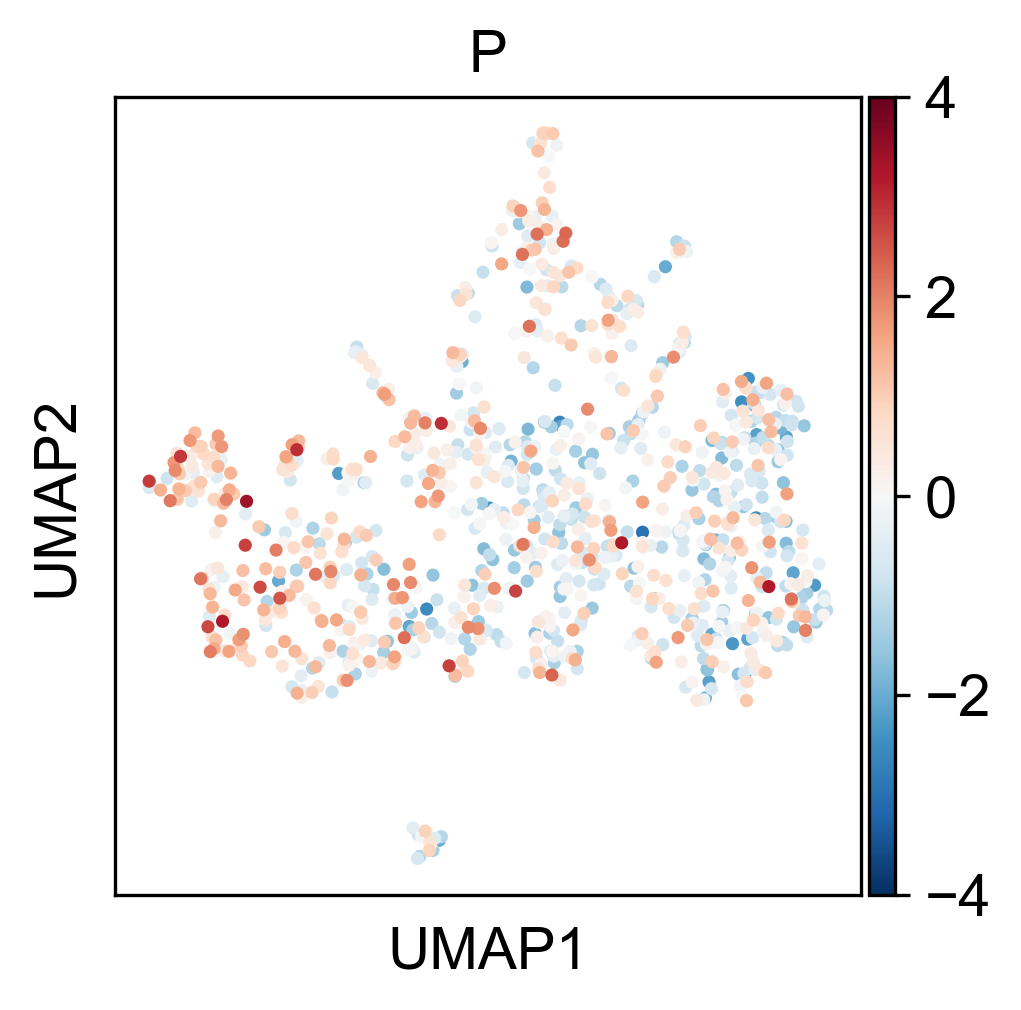

In [6]:
for key in dict_df_score:
    adata.obs[key] = dict_df_score[key]["norm_score"]


sc.set_figure_params(figsize=[3.5, 3.5], dpi=150)
sc.pl.umap(
    adata,
    color="leiden",
    ncols=1,
    color_map="RdBu_r",
    vmin=-5,
    vmax=5,
)

sc.pl.umap(
    adata,
    color=dict_df_score.keys(),
    color_map="RdBu_r",
    vmin=-4,
    vmax=4,
    s=40,
)



In [31]:
marker_genes = ['PLXNA4','TSC22D1','SOX11','TUBB2A',
                'RFTN2','CKB','SMC4','ZIC2',
                'DLX6-AS1','ADCY1','FOLR2','PDGFRB']

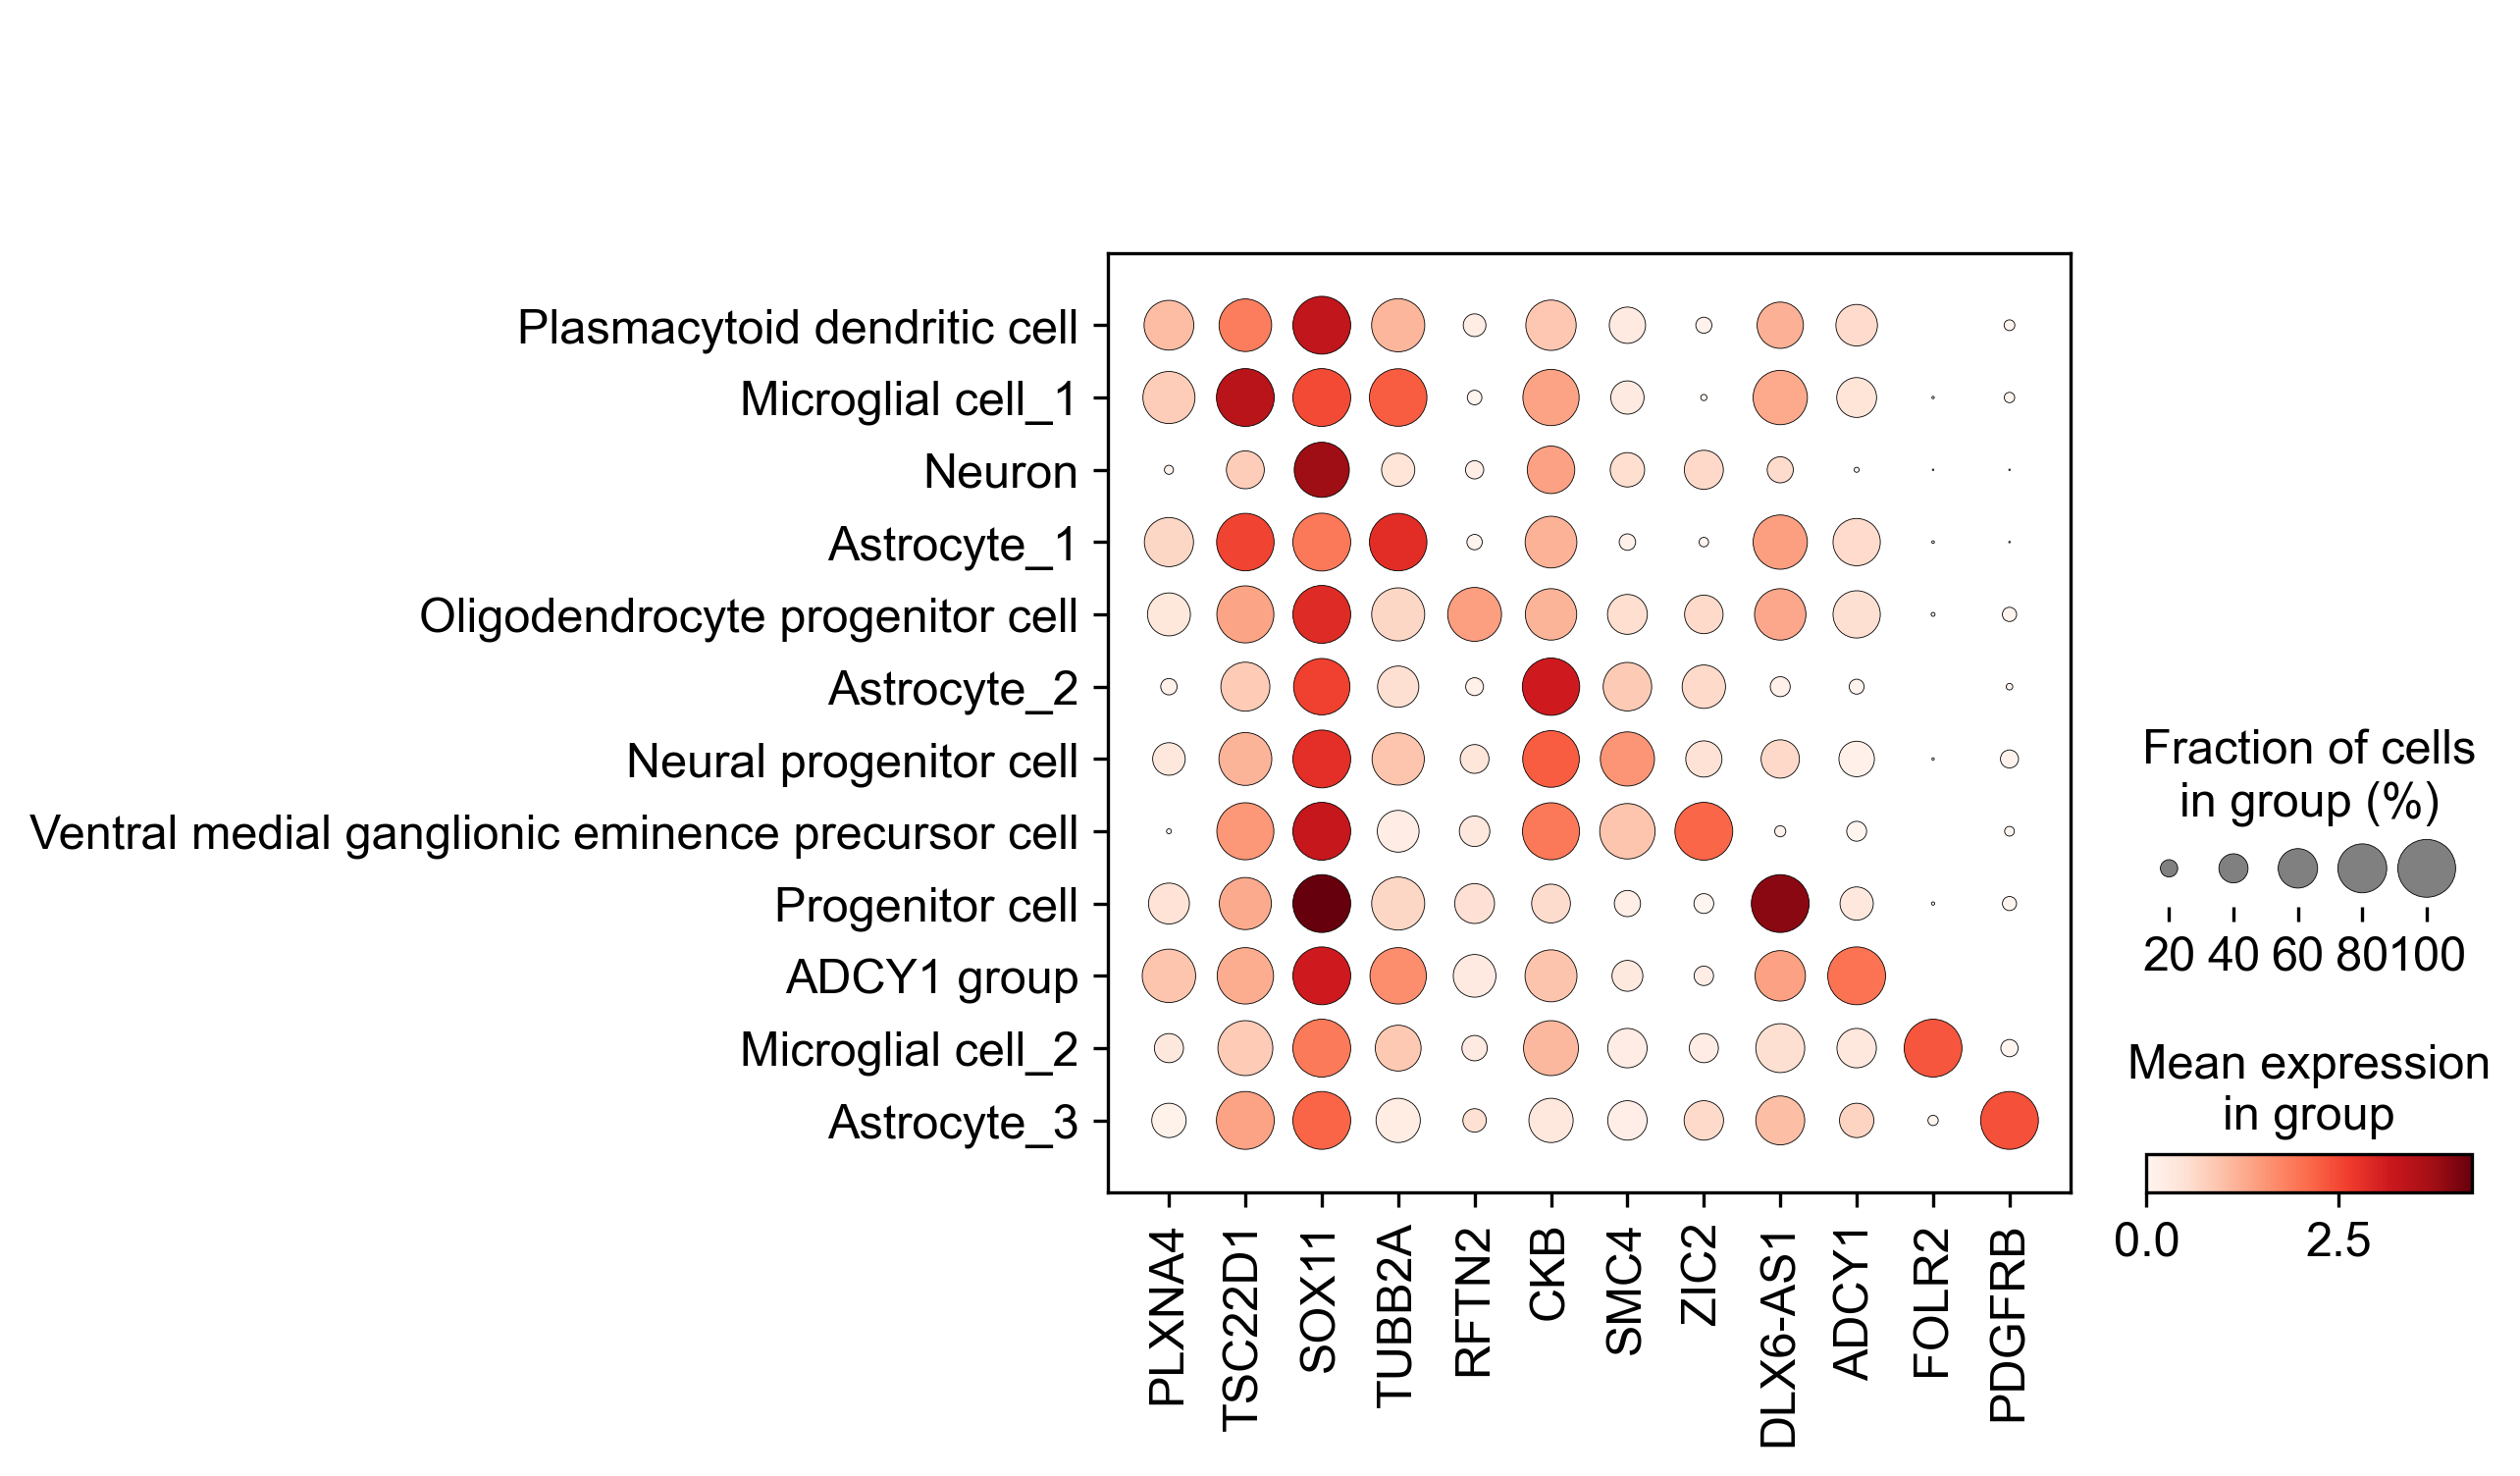

In [35]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden')

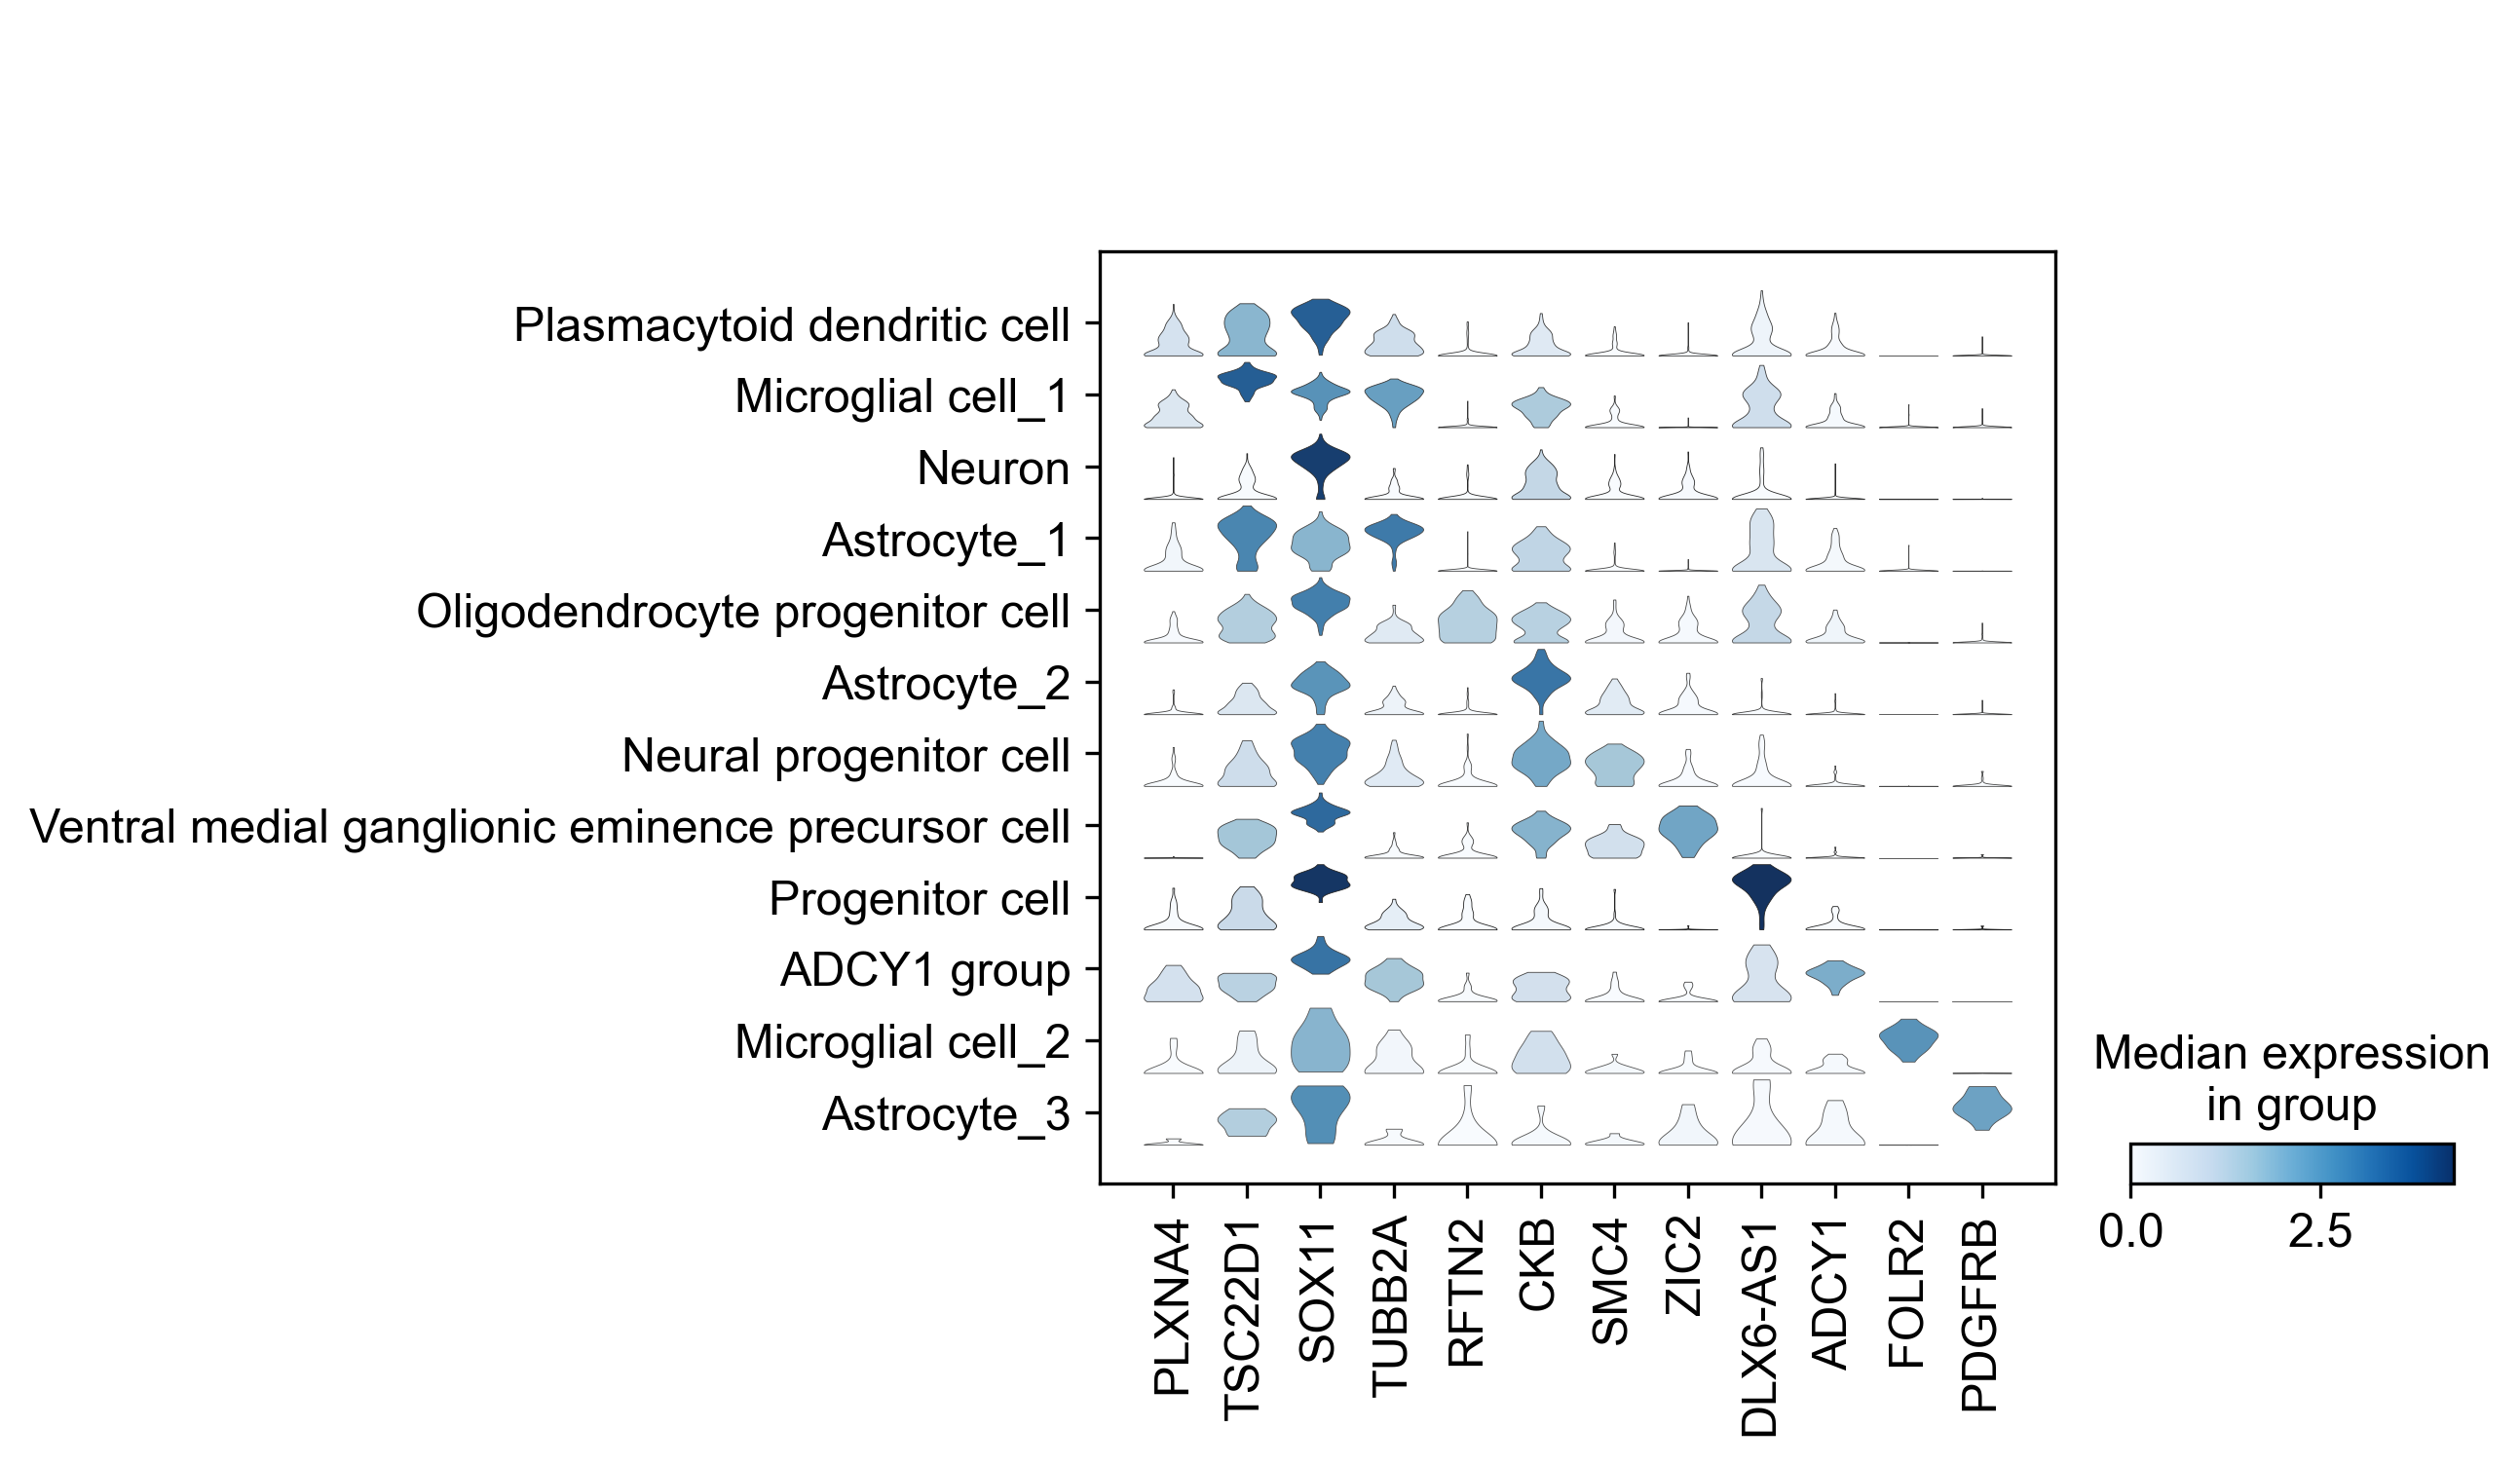

In [34]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90)

In [10]:
df_stats = scdrs.method.downstream_group_analysis(
    adata=adata,
    df_full_score=dict_df_score["P"],
    group_cols=["leiden"],
)["leiden"]

display(df_stats.style.set_caption("Group-level statistics for HEIGHT"))

,n_cell,n_ctrl,assoc_mcp,assoc_mcz,hetero_mcp,hetero_mcz,n_fdr_0.05,n_fdr_0.1,n_fdr_0.2
group,,,,,,,,,
ADCY1 group,30.000000,1000.000000,0.717283,-0.589166,0.779221,-0.743006,0.000000,0.000000,0.000000
Astrocyte_1,123.000000,1000.000000,0.976024,-1.807551,0.979021,-2.058282,0.000000,0.000000,0.000000
Astrocyte_2,91.000000,1000.000000,0.015984,2.341529,0.165834,0.942026,0.000000,0.000000,0.000000
Astrocyte_3,10.000000,1000.000000,0.532468,-0.121995,0.636364,-0.354241,0.000000,0.000000,0.000000
Microglial cell_1,138.000000,1000.000000,0.909091,-1.343815,0.553447,-0.093669,0.000000,0.000000,0.000000
Microglial cell_2,15.000000,1000.000000,0.362637,0.304035,0.102897,1.381178,0.000000,0.000000,0.000000
Microglial cell_3,160.000000,1000.000000,0.900100,-1.229257,0.787213,-0.770697,0.000000,0.000000,0.000000
Neural progenitor cell,71.000000,1000.000000,0.415584,0.215657,0.566434,-0.118603,0.000000,0.000000,0.000000
Neuron,130.000000,1000.000000,0.253746,0.610310,0.934066,-1.546990,0.000000,0.000000,0.000000


In [14]:
df_stats = scdrs.method.downstream_group_analysis(
    adata=adata,
    df_full_score=dict_df_score["BD_TWAS"],
    group_cols=["leiden"],
)["leiden"]

display(df_stats.style.set_caption("Group-level statistics for BD_TWAS"))

df_stats = scdrs.method.downstream_group_analysis(
    adata=adata,
    df_full_score=dict_df_score["BD_ATAC"],
    group_cols=["leiden"],
)["leiden"]

display(df_stats.style.set_caption("Group-level statistics for BD_ATAC"))

df_stats = scdrs.method.downstream_group_analysis(
    adata=adata,
    df_full_score=dict_df_score["BD_RNASeq"],
    group_cols=["leiden"],
)["leiden"]

display(df_stats.style.set_caption("Group-level statistics for BD_RNASeq"))

df_stats = scdrs.method.downstream_group_analysis(
    adata=adata,
    df_full_score=dict_df_score["BD_GWAS"],
    group_cols=["leiden"],
)["leiden"]

display(df_stats.style.set_caption("Group-level statistics for BD_GWAS"))


,n_cell,n_ctrl,assoc_mcp,assoc_mcz,hetero_mcp,hetero_mcz,n_fdr_0.05,n_fdr_0.1,n_fdr_0.2
group,,,,,,,,,
ADCY1 group,30.000000,1000.000000,0.267732,0.605821,0.057942,1.645159,0.000000,0.000000,0.000000
Astrocyte_1,123.000000,1000.000000,0.183816,0.909183,0.984016,-2.416647,0.000000,0.000000,0.000000
Astrocyte_2,91.000000,1000.000000,0.879121,-1.135441,0.374625,0.306335,0.000000,0.000000,0.000000
Astrocyte_3,10.000000,1000.000000,0.285714,0.553936,0.886114,-1.187930,0.000000,0.000000,0.000000
Microglial cell_1,138.000000,1000.000000,0.014985,2.447368,0.076923,1.467829,0.000000,0.000000,0.000000
Microglial cell_2,15.000000,1000.000000,0.876124,-1.127894,0.839161,-1.015501,0.000000,0.000000,0.000000
Neural progenitor cell,71.000000,1000.000000,0.689311,-0.540829,0.974026,-2.053566,0.000000,0.000000,0.000000
Neuron,130.000000,1000.000000,0.930070,-1.374765,0.025974,1.731877,0.000000,0.000000,0.000000
Oligodendrocyte progenitor cell,110.000000,1000.000000,0.981019,-1.900980,0.781219,-0.710407,0.000000,0.000000,0.000000


,n_cell,n_ctrl,assoc_mcp,assoc_mcz,hetero_mcp,hetero_mcz,n_fdr_0.05,n_fdr_0.1,n_fdr_0.2
group,,,,,,,,,
ADCY1 group,30.000000,1000.000000,0.148851,1.072135,0.575425,-0.203118,0.000000,0.000000,0.000000
Astrocyte_1,123.000000,1000.000000,0.109890,1.282428,0.333666,0.468607,0.000000,0.000000,0.000000
Astrocyte_2,91.000000,1000.000000,0.313686,0.506375,0.228771,0.754606,0.000000,0.000000,0.000000
Astrocyte_3,10.000000,1000.000000,0.199800,0.833950,0.192807,0.886591,0.000000,0.000000,0.000000
Microglial cell_1,138.000000,1000.000000,0.333666,0.426598,0.544456,-0.097238,0.000000,0.000000,0.000000
Microglial cell_2,15.000000,1000.000000,0.978022,-1.963020,0.950050,-1.669317,0.000000,0.000000,0.000000
Neural progenitor cell,71.000000,1000.000000,0.044955,1.766407,0.127872,1.149974,0.000000,0.000000,0.000000
Neuron,130.000000,1000.000000,0.511488,-0.067101,0.311688,0.497986,0.000000,0.000000,0.000000
Oligodendrocyte progenitor cell,110.000000,1000.000000,0.903097,-1.259333,0.471528,0.026183,0.000000,0.000000,0.000000


,n_cell,n_ctrl,assoc_mcp,assoc_mcz,hetero_mcp,hetero_mcz,n_fdr_0.05,n_fdr_0.1,n_fdr_0.2
group,,,,,,,,,
ADCY1 group,30.000000,1000.000000,0.048951,1.812704,0.589411,-0.226620,0.000000,0.000000,0.000000
Astrocyte_1,123.000000,1000.000000,0.601399,-0.309193,0.759241,-0.605439,0.000000,0.000000,0.000000
Astrocyte_2,91.000000,1000.000000,0.884116,-1.196355,0.749251,-0.615544,0.000000,0.000000,0.000000
Astrocyte_3,10.000000,1000.000000,0.000999,3.613622,0.897103,-1.345600,0.000000,1.000000,1.000000
Microglial cell_1,138.000000,1000.000000,0.985015,-1.889704,0.000999,2.805976,0.000000,0.000000,0.000000
Microglial cell_2,15.000000,1000.000000,0.000999,4.947937,0.828172,-0.969339,1.000000,3.000000,4.000000
Neural progenitor cell,71.000000,1000.000000,0.550450,-0.140514,0.011988,2.305288,0.000000,0.000000,0.000000
Neuron,130.000000,1000.000000,0.571429,-0.190844,0.212787,0.814467,0.000000,0.000000,0.000000
Oligodendrocyte progenitor cell,110.000000,1000.000000,0.013986,2.316037,0.262737,0.613961,0.000000,1.000000,1.000000


,n_cell,n_ctrl,assoc_mcp,assoc_mcz,hetero_mcp,hetero_mcz,n_fdr_0.05,n_fdr_0.1,n_fdr_0.2
group,,,,,,,,,
ADCY1 group,30.000000,1000.000000,0.537463,-0.143769,0.171828,0.971912,0.000000,0.000000,0.000000
Astrocyte_1,123.000000,1000.000000,0.453546,0.115839,0.918082,-1.375099,0.000000,0.000000,0.000000
Astrocyte_2,91.000000,1000.000000,0.379620,0.244161,0.898102,-1.286753,0.000000,0.000000,0.000000
Astrocyte_3,10.000000,1000.000000,0.606394,-0.301925,0.544456,-0.100627,0.000000,0.000000,0.000000
Microglial cell_1,138.000000,1000.000000,0.685315,-0.444980,0.196803,0.848389,0.000000,0.000000,0.000000
Microglial cell_2,15.000000,1000.000000,0.546454,-0.192741,0.774226,-0.819250,0.000000,0.000000,0.000000
Neural progenitor cell,71.000000,1000.000000,0.960040,-1.732131,0.610390,-0.179013,0.000000,0.000000,0.000000
Neuron,130.000000,1000.000000,0.237762,0.666625,0.015984,1.766858,0.000000,0.000000,0.000000
Oligodendrocyte progenitor cell,110.000000,1000.000000,0.736264,-0.647722,0.808192,-0.840368,0.000000,0.000000,0.000000


In [15]:
df_stats = scdrs.method.downstream_group_analysis(
    adata=adata,
    df_full_score=dict_df_score["HEIGHT_GWAS"],
    group_cols=["leiden"],
)["leiden"]

display(df_stats.style.set_caption("Group-level statistics for HEIGHT_GWAS"))


df_stats = scdrs.method.downstream_group_analysis(
    adata=adata,
    df_full_score=dict_df_score["HEIGHT"],
    group_cols=["leiden"],
)["leiden"]

display(df_stats.style.set_caption("Group-level statistics for HEIGHT"))

,n_cell,n_ctrl,assoc_mcp,assoc_mcz,hetero_mcp,hetero_mcz,n_fdr_0.05,n_fdr_0.1,n_fdr_0.2
group,,,,,,,,,
ADCY1 group,30.000000,1000.000000,0.896104,-1.215766,0.854146,-1.113065,0.000000,0.000000,0.000000
Astrocyte_1,123.000000,1000.000000,0.588412,-0.245669,0.803197,-0.830874,0.000000,0.000000,0.000000
Astrocyte_2,91.000000,1000.000000,0.002997,2.991905,0.083916,1.387154,0.000000,0.000000,0.000000
Astrocyte_3,10.000000,1000.000000,0.000999,3.834929,0.882118,-1.230931,0.000000,1.000000,1.000000
Microglial cell_1,138.000000,1000.000000,0.816184,-0.897961,0.192807,0.849147,0.000000,0.000000,0.000000
Microglial cell_2,15.000000,1000.000000,0.721279,-0.591790,0.067932,1.535269,0.000000,0.000000,0.000000
Neural progenitor cell,71.000000,1000.000000,0.051948,1.748935,0.125874,1.190957,0.000000,0.000000,0.000000
Neuron,130.000000,1000.000000,0.711289,-0.571909,0.223776,0.766970,0.000000,0.000000,0.000000
Oligodendrocyte progenitor cell,110.000000,1000.000000,0.010989,2.372585,0.007992,2.573129,0.000000,0.000000,0.000000


,n_cell,n_ctrl,assoc_mcp,assoc_mcz,hetero_mcp,hetero_mcz,n_fdr_0.05,n_fdr_0.1,n_fdr_0.2
group,,,,,,,,,
ADCY1 group,30.000000,1000.000000,0.012987,2.488830,0.027972,2.070109,0.000000,0.000000,0.000000
Astrocyte_1,123.000000,1000.000000,0.003996,2.790274,0.922078,-1.445607,0.000000,0.000000,0.000000
Astrocyte_2,91.000000,1000.000000,0.071928,1.537463,0.780220,-0.788722,0.000000,0.000000,0.000000
Astrocyte_3,10.000000,1000.000000,0.478521,-0.026359,0.283716,0.624391,0.000000,0.000000,0.000000
Microglial cell_1,138.000000,1000.000000,0.577423,-0.264906,0.977023,-2.041826,0.000000,0.000000,0.000000
Microglial cell_2,15.000000,1000.000000,0.991009,-2.087911,0.560440,-0.162558,0.000000,0.000000,0.000000
Neural progenitor cell,71.000000,1000.000000,0.990010,-2.298598,0.060939,1.592854,0.000000,0.000000,0.000000
Neuron,130.000000,1000.000000,0.760240,-0.697523,0.394605,0.306800,0.000000,0.000000,0.000000
Oligodendrocyte progenitor cell,110.000000,1000.000000,0.244755,0.650363,0.769231,-0.770388,0.000000,0.000000,0.000000


In [ ]:
# scDRS group-level statistics for BD
!cat data/BD.scdrs_group.leiden | column -t -s $'\t'

In [12]:
adata

AnnData object with n_obs × n_vars = 978 × 7026
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'SCDRS_PARAM'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
type(names) #判断数据类型

In [ ]:
#保存LIST为txt文件
filename = open('name.txt', 'w')
for value in names:
        filename.write(str(value))
        filename.write('\n')
filename.close()

In [13]:
#创建脑区的
sd=pd.read_csv('E:/anaconda/jupyter notebook/cell_tissue.csv',header=None,names=['cell_name', 'brain_tissue'],
              index_col=0)

In [14]:
sd

,brain_tissue
cell_name,
X.data.sqcheng.boluncheng.Proj_scDRSbam.03_align_all.C1.133.A1_TAAGGCGA.GCGTAAGA_L005_R1_merged_trimmed.fq.gz.hs2.bam,cortical plate
X.data.sqcheng.boluncheng.Proj_scDRSbam.03_align_all.C1.133.A10_CGAGGCTG.GCGTAAGA_L005_R1_001_trimmed.fq.gz.hs2.bam,cortical plate
X.data.sqcheng.boluncheng.Proj_scDRSbam.03_align_all.C1.133.A12_GTAGAGGA.GCGTAAGA_L005_R1_001_trimmed.fq.gz.hs2.bam,cortical plate
X.data.sqcheng.boluncheng.Proj_scDRSbam.03_align_all.C1.133.A2_CGTACTAG.GCGTAAGA_L005_R1_001_trimmed.fq.gz.hs2.bam,cortical plate
X.data.sqcheng.boluncheng.Proj_scDRSbam.03_align_all.C1.133.A3_AGGCAGAA.GCGTAAGA_L005_R1_001_trimmed.fq.gz.hs2.bam,cortical plate
...,...
X.data.sqcheng.boluncheng.Proj_scDRSbam.03_align_all.PEC_Yale_SingleCellRNAseq_HSB325_72_H3_trimmed.fq.gz.hs2.bam,dorsal pallium
X.data.sqcheng.boluncheng.Proj_scDRSbam.03_align_all.PEC_Yale_SingleCellRNAseq_HSB325_72_H4_trimmed.fq.gz.hs2.bam,dorsal pallium
X.data.sqcheng.boluncheng.Proj_scDRSbam.03_align_all.PEC_Yale_SingleCellRNAseq_HSB325_72_H5_trimmed.fq.gz.hs2.bam,dorsal pallium


In [15]:
adata.obs["tissue"] = sd

In [16]:
adata

AnnData object with n_obs × n_vars = 978 × 7026
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'tissue'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'SCDRS_PARAM'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [17]:
adata.obs.tissue

X.data.sqcheng.boluncheng.Proj_scDRSbam.03_align_all.C1.133.A10_CGAGGCTG.GCGTAAGA_L005_R1_001_trimmed.fq.gz.hs2.bam      cortical plate
X.data.sqcheng.boluncheng.Proj_scDRSbam.03_align_all.C1.133.A12_GTAGAGGA.GCGTAAGA_L005_R1_001_trimmed.fq.gz.hs2.bam      cortical plate
X.data.sqcheng.boluncheng.Proj_scDRSbam.03_align_all.C1.133.A1_TAAGGCGA.GCGTAAGA_L005_R1_merged_trimmed.fq.gz.hs2.bam    cortical plate
X.data.sqcheng.boluncheng.Proj_scDRSbam.03_align_all.C1.133.A2_CGTACTAG.GCGTAAGA_L005_R1_001_trimmed.fq.gz.hs2.bam       cortical plate
X.data.sqcheng.boluncheng.Proj_scDRSbam.03_align_all.C1.133.A3_AGGCAGAA.GCGTAAGA_L005_R1_001_trimmed.fq.gz.hs2.bam       cortical plate
                                                                                                                              ...      
X.data.sqcheng.boluncheng.Proj_scDRSbam.03_align_all.PEC_Yale_SingleCellRNAseq_HSB325_72_H3_trimmed.fq.gz.hs2.bam        dorsal pallium
X.data.sqcheng.boluncheng.Proj_scDRSbam.03_align

In [36]:
results_file = 'E:/anaconda/jupyter notebook/bd_brain.h5ad' 
adata.write(results_file)

In [37]:
adata.obs.leiden

X.data.sqcheng.boluncheng.Proj_scDRSbam.03_align_all.C1.133.A10_CGAGGCTG.GCGTAAGA_L005_R1_001_trimmed.fq.gz.hs2.bam                      Astrocyte_1
X.data.sqcheng.boluncheng.Proj_scDRSbam.03_align_all.C1.133.A12_GTAGAGGA.GCGTAAGA_L005_R1_001_trimmed.fq.gz.hs2.bam      Plasmacytoid dendritic cell
X.data.sqcheng.boluncheng.Proj_scDRSbam.03_align_all.C1.133.A1_TAAGGCGA.GCGTAAGA_L005_R1_merged_trimmed.fq.gz.hs2.bam                    Astrocyte_1
X.data.sqcheng.boluncheng.Proj_scDRSbam.03_align_all.C1.133.A2_CGTACTAG.GCGTAAGA_L005_R1_001_trimmed.fq.gz.hs2.bam                       Astrocyte_1
X.data.sqcheng.boluncheng.Proj_scDRSbam.03_align_all.C1.133.A3_AGGCAGAA.GCGTAAGA_L005_R1_001_trimmed.fq.gz.hs2.bam                 Microglial cell_1
                                                                                                                                    ...             
X.data.sqcheng.boluncheng.Proj_scDRSbam.03_align_all.PEC_Yale_SingleCellRNAseq_HSB325_72_H3_trimmed.fq.gz.